# <i>The impact of pagerank-index in quantifying the performance of scientists in the field of Quantum Game Theory </i>


In [1]:
!pip install ipynb
from ipynb.fs.full.utility import *

In [1]:
!git clone https://github.com/marijakatic/pindex.git 2> pindex_clone.log

We will demonstrate the utility of the Pagerank-index by applying it to a real-world dataset (uploaded <a href="https://github.com/marijakatic/pindex">here</a>). This is citation network of papers and authors in the field of Quantum Game Theory (QGT). The dataset was manually prepared by the authors of The Pagerank-index.

*This field (as defined by the Google scholar profile) has achieved sufficient growth to facilitate a meaningful analysis (at time of access, it contained 685 papers, 785 authors, and 3776 citations), at the same time it is sufficiently young such that the growth of the field could be traced back to the ‘first’ papers.*


## Load data from files

### Numbered files - files with citations

Each paper in the field is assigned an ID (from 1 to 685). The IDs are in the order of publication.
Each paper has a list of references (a list of these IDs) in a separate file.

For example, file 90.txt:

```
38
50
45
79
```  
  

This is interpreted as the paper ID=90 cites the paper/s with the above IDs from papernet file 90.txt.

ie: paper ID=90 cites papers ID=38, ID=50, ID=45, ID=79.

Since the IDs are in the order of publication, paper ID=1 was the first one to be published and paper ID=685 was the last one to be published. Paper ID=i would have been published before paper ID=i+1.


In [3]:
N_papers = 685

citations = []
# invalid citation - if paper that cites is older than cited one
invalid_citations = []
# source - paper that cites, target - cited by source
for source in range(0, N_papers):
    with open('./pindex/QGT/' + str(source+1) + '.txt') as f:
        targets = f.readlines()
        for target in targets:
            target = int(target.strip()) - 1
            if source > target:
                citations.append((source, target))
            else:
                invalid_citations.append((source, target))

In [4]:
citations[:5]

[(5, 3), (9, 6), (17, 14), (19, 14), (24, 6)]

In [5]:
print("There is", len(citations), "valid citations")

There is 3660 valid citations


In [6]:
invalid_citations[:5]

[(49, 52), (85, 122), (90, 126), (90, 105), (92, 120)]

In [7]:
print("There is", len(invalid_citations), "invalid citations.")
print("That is {}% of all citations.".format(int(100 * len(invalid_citations)/(len(citations)+len(invalid_citations)))))

There is 139 invalid citations.
That is 3% of all citations.


I will ignore invalid citations.

### papernet.txt

*The file named papernet contains the name of each paper and it's respective author/s as a comma separated list and each paper is separated by a line break.*

*Example:*

*Utility of information game theoretic approach, H Everett*

In [8]:
with open('./pindex/QGT/papernet.txt', encoding='utf8', mode='r') as f:
    papers_data = f.readlines()

In [9]:
papers_data[:5]

['Utility of information game theoretic approach, H Everett\n',
 'A GLOBAL THEORY FOR LINEAR QUADRATIC DIFFERENTIAL GAMES, DL Lukes, DL Russell\n',
 'A quantum shuffling game for teaching statistical mechanics, PJ Black, P Davies, JM Ogborn\n',
 'A max-min differential game in Hilbert space, JE ROBERT\n',
 'Statistical decision theory for quantum systems, AS Holevo\n']

In [10]:
len(papers_data)

685

In [11]:
papers_data = [list(map(str.strip, p.split(','))) for p in papers_data]
papers_data[:5]

[['Utility of information game theoretic approach', 'H Everett'],
 ['A GLOBAL THEORY FOR LINEAR QUADRATIC DIFFERENTIAL GAMES',
  'DL Lukes',
  'DL Russell'],
 ['A quantum shuffling game for teaching statistical mechanics',
  'PJ Black',
  'P Davies',
  'JM Ogborn'],
 ['A max-min differential game in Hilbert space', 'JE ROBERT'],
 ['Statistical decision theory for quantum systems', 'AS Holevo']]

There are some lines like this:
\*repeated-32\*. <br>
We will repeat data from specified lines:

In [12]:
import re
for i in range(len(papers_data)):
    if len(papers_data[i]) == 1:
        m = re.search(r'\*[rR]epeated-([0-9]*)\*', papers_data[i][0])
        to_repeat = int(m.group(1))
        papers_data[i] = papers_data[to_repeat-1]

## Make a citation database

In [13]:
db = CitationDatabase()

### Add authors  and papers to the citation database

In [14]:
author_names = {}
for i in range(len(papers_data)):
    title = papers_data[i][0]
    author_list = []
    for author_name in papers_data[i][1:]:
            if not author_name in author_names:
                author_id = db.new_author_id()
                new_author = Author(db, author_id, name=author_name)
                author_list.append(new_author)
                author_names[author_name] = new_author
            else:
                author_list.append(author_names[author_name])
    # print(author_list)
    Paper(db, paper_id=i, title=title, author_list=author_list)

In [15]:
print("There are", len(db.all_papers), "papres in citation database now.")

There are 685 papres in citation database now.


In [16]:
print("There are", len(db.all_authors), "authors in citation database now.")

There are 806 authors in citation database now.


In [17]:
db.all_papers[0]

Paper 0 | Utility of information game theoretic approach | H Everett

### Add citations to the citation database

In [18]:
for citation in citations:
    db.add_citation(citation)

## Calculate all necessary indices (rankings) based on citations from the database

In [19]:
db.ranking_update()

## Plot rankings

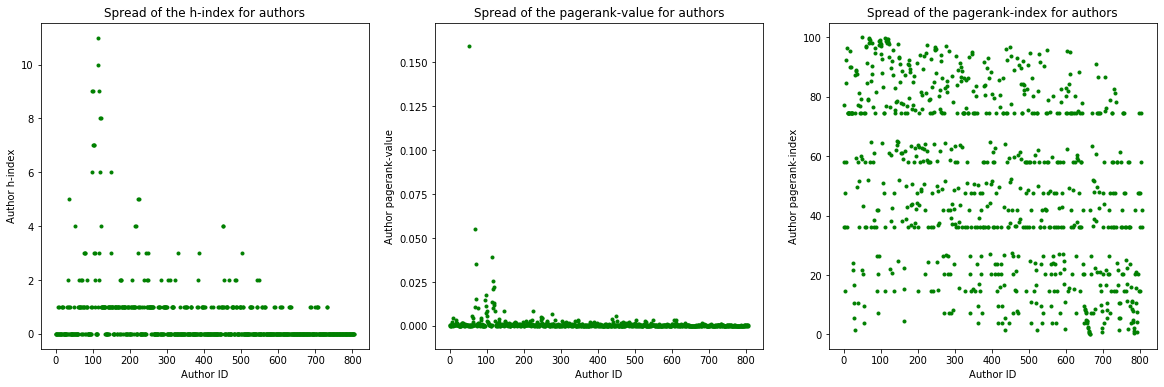

In [20]:
plot_indices(db, marker_pos='.', legend=False)

## Let's dive deeper

In [21]:
QGTauthors = db.all_authors

In [22]:
QGTauthors_sorted_by_h = sorted(QGTauthors, key=lambda author: author.h_index, reverse=True)

In [23]:
QGTauthors_sorted_by_pi = sorted(QGTauthors, key=lambda author: author.pagerank_index, reverse=True)

In [24]:
data_h = []
# rank of author in list sorted by h-index
rank_h = 1
for a in QGTauthors_sorted_by_h[:12]:
    # average authors per paper of author a
    avg_authors_per_paper = 0
    for paper in a.paper_list:
        avg_authors_per_paper += paper.num_of_authors
    avg_authors_per_paper /= len(a.paper_list)
    # rank of author a in the list sorted by pi
    rank_pi = QGTauthors_sorted_by_pi.index(a) + 1
    data_h.append([a.author_id, a.name, a.h_index, 
                 round(a.pagerank_index,2), len(a.paper_list), round(avg_authors_per_paper, 2), 
                 rank_h, rank_pi])
    rank_h += 1

In [25]:
data_pi = []
# rank of author in list sorted by pagerank-index
rank_pi = 1
for a in QGTauthors_sorted_by_pi[:12]:
    # average authors per paper of author a
    avg_authors_per_paper = 0
    for paper in a.paper_list:
        avg_authors_per_paper += paper.num_of_authors
    avg_authors_per_paper /= len(a.paper_list)
    # rank of author a in the list sorted by h-index
    rank_h = QGTauthors_sorted_by_h.index(a) + 1
    data_pi.append([a.author_id, a.name, a.h_index, 
                 round(a.pagerank_index,2), len(a.paper_list), round(avg_authors_per_paper, 2), 
                 rank_h, rank_pi])
    rank_pi += 1

In [26]:
import pandas as pd

In [27]:
columns = ["ID", "Author", "h-index", "pagerank-index", "papers", "avg. authors per paper", "rank-h", "rank-pi"]

In [28]:
data_h = pd.DataFrame(data_h, columns=columns)
data_h

,ID,Author,h-index,pagerank-index,papers,avg. authors per paper,rank-h,rank-pi
0,113,A Iqbal,11,99.75,49,2.57,1,3
1,114,AH Toor,10,98.76,20,2.10,2,11
2,99,J Du,9,98.39,15,4.67,3,14
3,101,H Li,9,97.89,12,4.67,4,18
4,118,AP Flitney,9,99.50,27,2.33,5,5
5,120,EW Piotrowski,8,99.38,22,2.23,6,6
6,121,J Sladkowski,8,98.64,23,2.26,7,12
7,100,X Xu,7,97.02,8,5.50,8,25
8,102,X Zhou,7,94.42,9,5.33,9,46
9,103,R Han,7,88.09,8,5.50,10,97


<b>R Han (ID=103) is 97th in pagerank-index ranking. What's the "problem" with him?</b>

In [29]:
han = db.all_authors[103]
han

Author 103 | R Han | [61, 63, 69, 83, 102, 125, 150, 162]

In [30]:
han.paper_list

[Paper 61 | Nash equilibrium in the quantum battle of sexes game | J Du, X Xu, H Li, X Zhou, R Han,
 Paper 63 | Quantum strategy without entanglement | J Du, X Xu, H Li, M Shi, X Zhou, R Han,
 Paper 69 | Remark on quantum battle of the sexes game | J Du, H Li, X Xu, M Shi, X Zhou, R Han,
 Paper 83 | Entanglement playing a dominating role in quantum games | J Du, X Xu, H Li, X Zhou, R Han,
 Paper 102 | Experimental realization of quantum games on a quantum computer | J Du, H Li, X Xu, M Shi, J Wu, X Zhou, R Han,
 Paper 125 | Entanglement enhanced multiplayer quantum games | J Du, H Li, X Xu, X Zhou, R Han,
 Paper 150 | Playing prisoner's dilemma with quantum rules | J Du, X Xu, H Li, X Zhou, R Han,
 Paper 162 | Phase-transition-like behaviour of quantum games | J Du, H Li, X Xu, X Zhou, R Han]

In [31]:
han_papers_ids = [paper.paper_id for paper in han.paper_list]
han_papers_ids

[61, 63, 69, 83, 102, 125, 150, 162]

In [32]:
avg_pvalue = 0
for citation in db.citations:
    if citation[1] in han_papers_ids:
        avg_pvalue += db.all_papers[citation[0]].pagerank_value
        if citation[0] in han_papers_ids:
            print("Citation by himself: ", citation)
avg_pvalue /= han.citation_count
print("Average pvalue of paper that cites Han's paper: ", avg_pvalue)

Citation by himself:  (63, 61)
Citation by himself:  (125, 83)
Citation by himself:  (125, 102)
Citation by himself:  (150, 83)
Citation by himself:  (150, 102)
Citation by himself:  (150, 125)
Citation by himself:  (162, 102)
Citation by himself:  (162, 125)
Average pvalue of paper that cites Han's paper:  0.0011928271399986058


In [33]:
data_pi = pd.DataFrame(data_pi, columns=columns)
data_pi

,ID,Author,h-index,pagerank-index,papers,avg. authors per paper,rank-h,rank-pi
0,51,DA Meyer,4,100.00,8,1.75,17,1
1,69,J Eisert,2,99.88,2,2.50,38,2
2,113,A Iqbal,11,99.75,49,2.57,1,3
3,70,M Wilkens,2,99.63,2,2.50,39,4
4,118,AP Flitney,9,99.50,27,2.33,5,5
5,120,EW Piotrowski,8,99.38,22,2.23,6,6
6,116,SC Benjamin,3,99.26,4,2.50,28,7
7,98,NF Johnson,6,99.13,10,2.10,11,8
8,71,M Lewenstein,1,99.01,1,3.00,77,9
9,96,L Marinatto,1,98.88,1,2.00,84,10


<b>L Marinatto (ID=96) is 84th in h-index ranking. What's the "problem" with him?</b>

In [34]:
print(db.all_authors[96])

Author 96 | L Marinatto | [58]


We see that Marinatto has only one paper.

In [35]:
db.all_papers[58]

Paper 58 | A quantum approach to static games of complete information | L Marinatto, T Weber

In [36]:
print("Marinatto's paper is cited", db.all_papers[58].citation_count, "times.")

Marinatto's paper is cited 154 times.


In [37]:
print("p-value of paper 59 is", db.all_papers[58].pagerank_value)

p-value of paper 59 is 0.02181445269833789


In [38]:
print("Average p-value of papers is {}".format(sum(db.paper_pvalues.values())/len(db.paper_pvalues)))

Average p-value of papers is 0.0014598540145985364


But pvalue of his only paper is high.

## Visualization of the citation network

In [39]:
import numpy.random as random

In [40]:
num_of_edges = len(db.G.edges)
num_of_edges

3647

Number of edges is large. So let's draw some random subgraph. <br>
We will choose 500 random edges from original graph and draw subgraph induced by that edges.

In [41]:
random_edge_indices = list(random.choice(range(num_of_edges), size=500, replace=False))

In [42]:
random_edges = [list(db.G.edges)[i] for i in random_edge_indices]

In [43]:
G_subgraph = db.G.edge_subgraph(random_edges)

In [44]:
len(G_subgraph.edges)

500

In [45]:
len(G_subgraph.nodes)

341

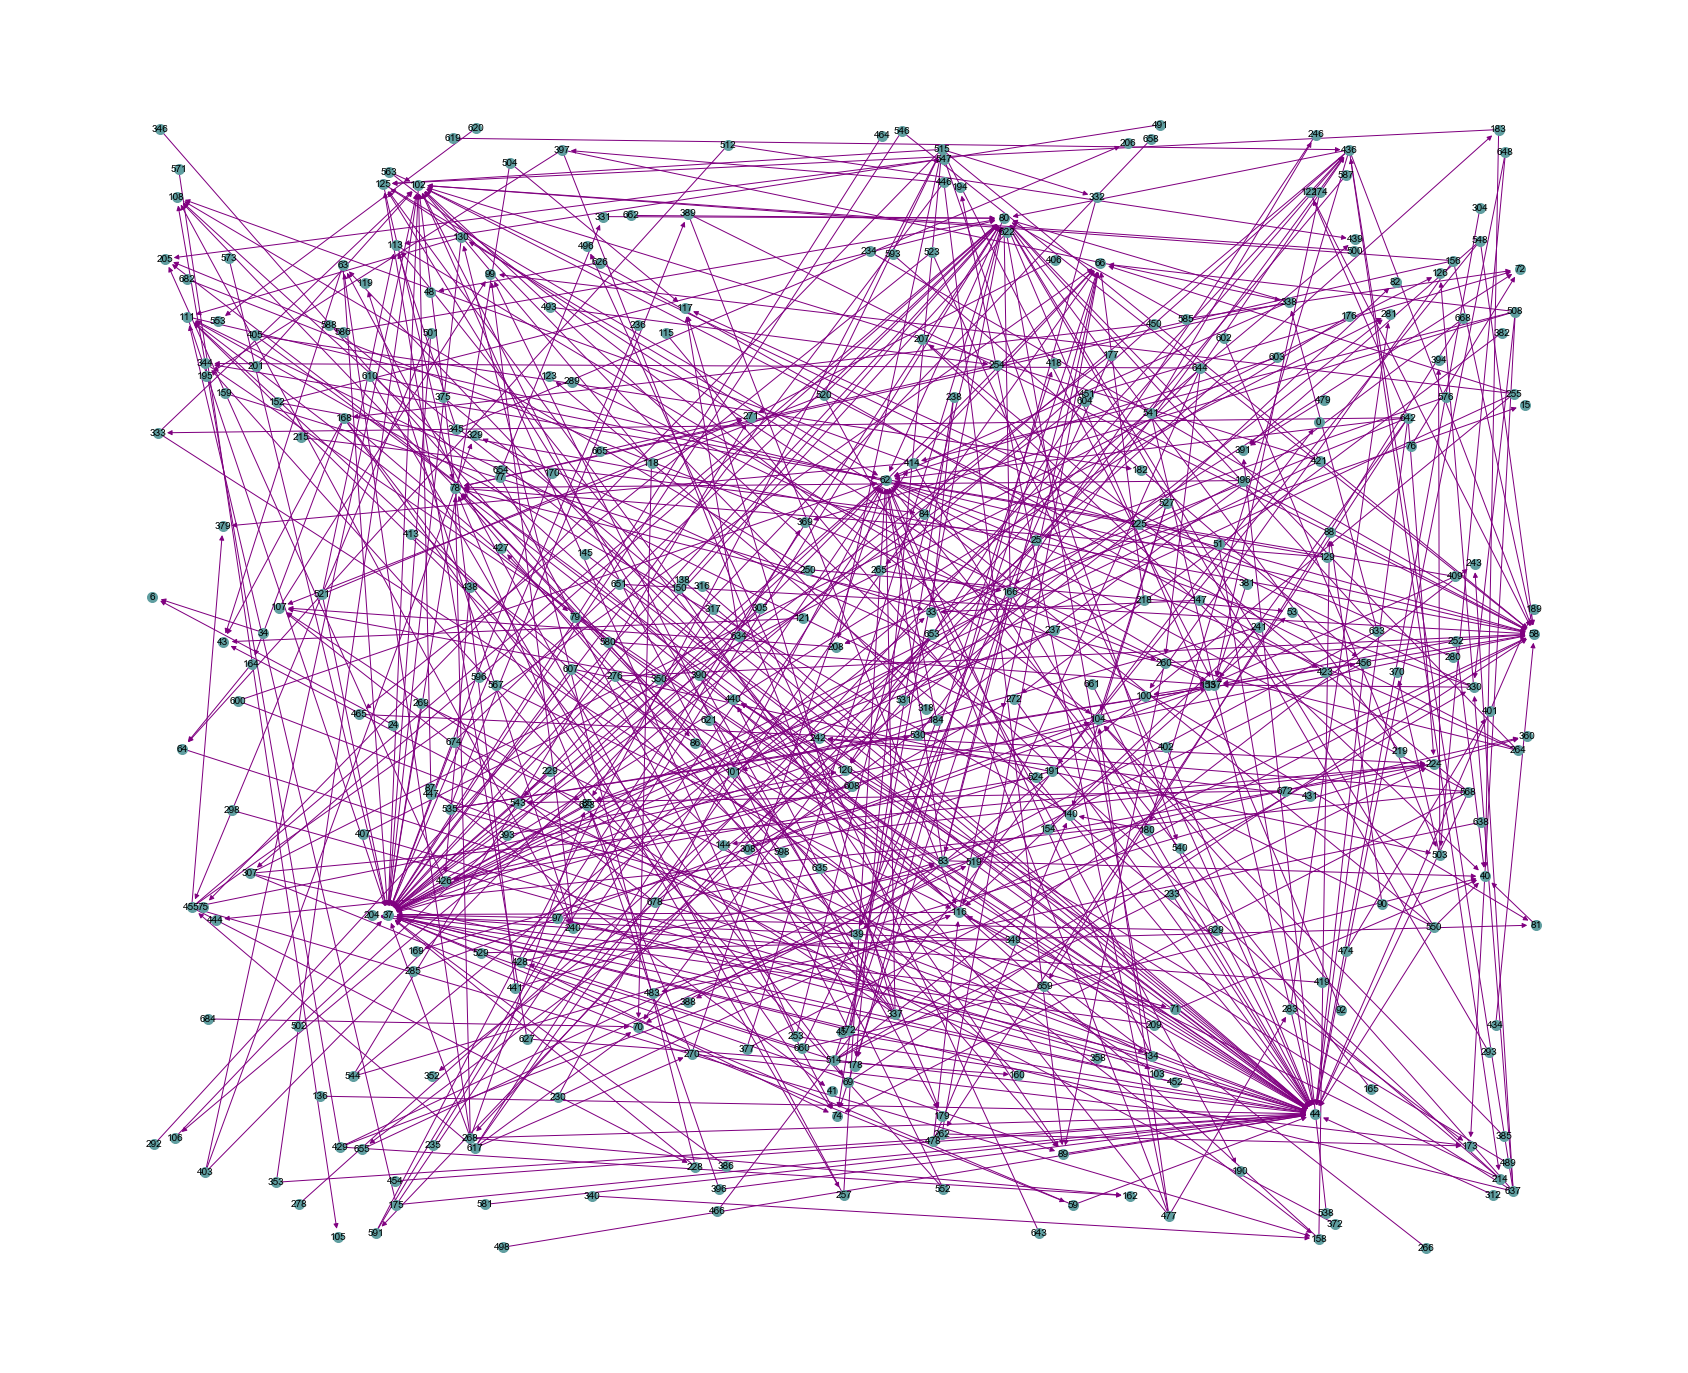

In [46]:
draw_graph(G_subgraph, 'random-QGT-subgraph.jpg')

We have noticed that node 37 is especially "popular".
Let's see what is paper 37 and whose this paper is.

In [47]:
db.all_papers[37]

Paper 37 | Quantum strategies | DA Meyer

In [48]:
db.all_papers[37].author_list

[Author 51 | DA Meyer | [33, 37, 49, 89, 105, 147, 223, 459]]

In [49]:
print("Meyer's pagerank-index is", db.all_authors[51].pagerank_index)

Meyer's pagerank-index is 100.0


Node 44 is also "popular":

In [50]:
db.all_papers[44]

Paper 44 | Quantum games and quantum strategies | J Eisert, M Wilkens, M Lewenstein